In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_squared_error
)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqUtils import gc_fraction
import random

In [2]:
df = pd.read_csv("cleaned_features.csv")

# Identifies metadata (to drop from X)
meta_cols = ["Gene Name", "Accession", "Organism", "Taxonomy", "Molecule_type"]

# Identifies numeric feature columns automatically
numeric_cols = [c for c in df.columns if c not in meta_cols]

#Each gene is mapped to a functionality
function_map = {
    "BRCA1": "DNA Repair",
    "TP53": "Tumor Suppressor",
    "APOE": "Lipid Transport",
    "CFTR": "Ion Channel",
    "FBN1": "Structural Protein",
    "ACTB": "Cytoskeleton",
    "COX1": "Mitochondrial Respiration",
    "RPLP0": "Ribosomal Protein",
    "GAPDH": "Metabolism",
    "HBB": "Oxygen Transport",
    "DMD": "Muscle Structural Protein",
    "HTT": "Neuronal Signaling",
    "BRCA2": "Genome Stability",
    "HPRT1": "Purine Metabolism",
    "B2M": "Immune System"
}

# Create a column for gene functionality
df["Function"] = df["Gene Name"].map(function_map)

le = LabelEncoder()
df["Function_Label"] = le.fit_transform(df["Function"])

# Predictor data vs Prediction data
X = df[numeric_cols]
y = df["Function_Label"]

#Data validation and cleaning for model implementation
counts = y.value_counts()
rare = counts[counts<2].index


mask = ~y.isin(rare)
y_filtered = y[mask]
X_filtered = X[mask]


df.head()


,Gene Name,Accession,Organism,Taxonomy,Molecule_type,Sequence_length,cds_start,cds_end,cds_length,protein length,...,aa_P,aa_Q,aa_R,aa_S,aa_T,aa_V,aa_W,aa_Y,Function,Function_Label
0,BRCA1,XM_077853395,Canis aureus,Eukaryota;Metazoa;Chordata;Craniata;Vertebrata...,mRNA,3804,268,2704,2436,811,...,5.178792,6.041924,4.685573,12.823674,5.425401,5.918619,0.863132,1.726264,DNA Repair,1
1,BRCA1,XM_077853393,Canis aureus,Eukaryota;Metazoa;Chordata;Craniata;Vertebrata...,mRNA,3845,270,2745,2475,824,...,5.218447,6.067961,4.733010,12.621359,5.582524,5.825243,0.849515,1.699029,DNA Repair,1
2,BRCA1,XM_077853392,Canis aureus,Eukaryota;Metazoa;Chordata;Craniata;Vertebrata...,mRNA,6998,261,5898,5637,1878,...,5.165069,5.591054,4.898829,13.099042,5.484558,5.963791,0.532481,1.224707,DNA Repair,1
3,BRCA1,XM_077853391,Canis aureus,Eukaryota;Metazoa;Chordata;Craniata;Vertebrata...,mRNA,6876,139,5776,5637,1878,...,5.165069,5.591054,4.898829,13.099042,5.484558,5.963791,0.532481,1.224707,DNA Repair,1
4,BRCA1,XM_077853390,Canis aureus,Eukaryota;Metazoa;Chordata;Craniata;Vertebrata...,mRNA,6940,203,5840,5637,1878,...,5.165069,5.591054,4.898829,13.099042,5.484558,5.963791,0.532481,1.224707,DNA Repair,1


In [3]:
# 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)

In [4]:
# Scale Data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),
                               columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                            columns=X_test.columns)

In [5]:
#Model 1 - Logistic Regression
print("=== Logistic Regression ===")
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train_scaled, y_train)

y_pred_lr = clf_lr.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr, average='macro'))
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

=== Logistic Regression ===
Accuracy: 0.9927272727272727
F1 Score: 0.9911169971428222
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       0.95      1.00      0.98        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00        20
           9       1.00      0.95      0.97        20
          10       1.00      0.89      0.94         9
          11       1.00      1.00      1.00        20
          12       0.95      1.00      0.98        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20

    accuracy                           0.99     

In [6]:
# Model 2 - Naive Bayes(GaussianNB)
print("=== Naive Bayes ===")
clf_nb = GaussianNB()
clf_nb.fit(X_train_scaled, y_train)

y_pred_nb = clf_nb.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1 Score:", f1_score(y_test, y_pred_nb, average='macro'))
print(classification_report(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))

=== Naive Bayes ===
Accuracy: 0.9636363636363636
F1 Score: 0.9489775109223119
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       1.00      1.00      1.00        20
           2       0.95      1.00      0.98        20
           3       0.91      1.00      0.95        20
           4       1.00      1.00      1.00        20
           5       1.00      0.95      0.97        20
           6       1.00      1.00      1.00        20
           7       0.50      1.00      0.67         6
           8       0.95      0.95      0.95        20
           9       1.00      0.90      0.95        20
          10       1.00      0.78      0.88         9
          11       1.00      1.00      1.00        20
          12       1.00      0.95      0.97        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20

    accuracy                           0.96       275
  

In [7]:
#Model 3 - Random Forest **Decided to use this as our main model** 
print("=== Random Forest ===")
clf_rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')

clf_rf.fit(X_train_scaled, y_train)

y_pred_rf = clf_rf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf, average='macro'))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

=== Random Forest ===
Accuracy: 0.9854545454545455
F1 Score: 0.98305363157738
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       0.95      1.00      0.98        20
           3       0.91      1.00      0.95        20
           4       1.00      1.00      1.00        20
           5       1.00      0.90      0.95        20
           6       1.00      1.00      1.00        20
           7       0.86      1.00      0.92         6
           8       1.00      1.00      1.00        20
           9       1.00      0.90      0.95        20
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        20
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20

    accuracy                           0.99       275
  

 99%|===================| 4092/4125 [01:10<00:00]        

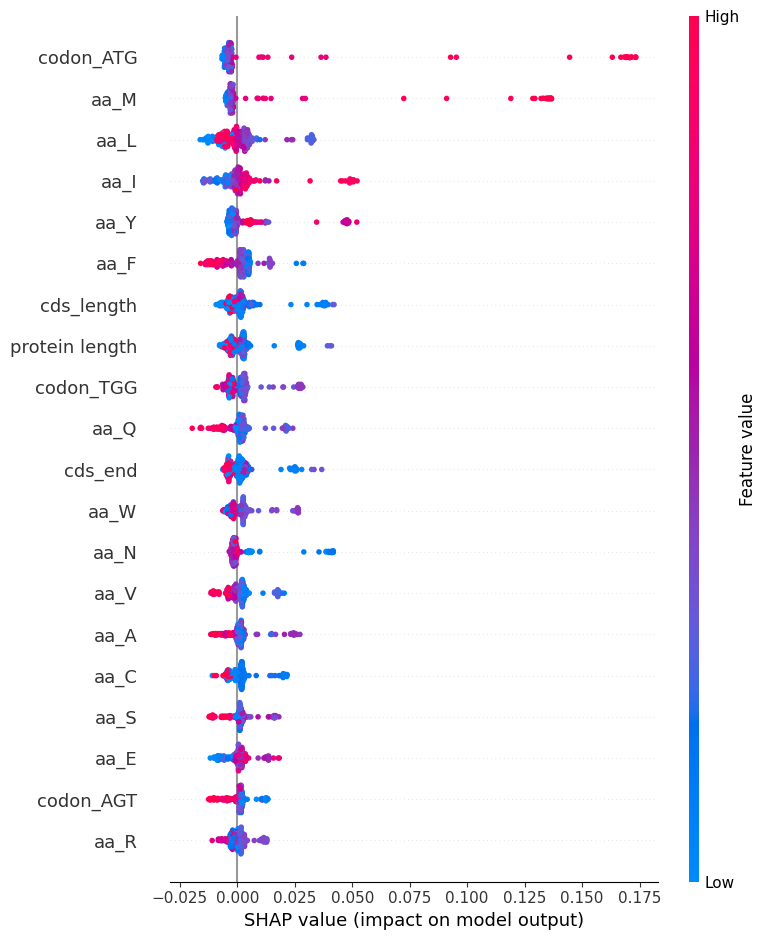

'\nThe further right the dot → the more it increases the predicted probability of the target class.\n\nThe further left the dot → the more it decreases the probability.\n'

In [8]:
X_train_df = pd.DataFrame(X_train_scaled, columns=numeric_cols)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=numeric_cols)

# Initializing JS visualization
shap.initjs()

#Creating a TreeExplainer that is forced to stay in tree mode
explainer = shap.TreeExplainer(
    clf_rf,
    data=X_train_df,
    feature_perturbation="interventional",
    model_output="raw"   
)

raw_shap_values = explainer.shap_values(X_test_df)


if isinstance(raw_shap_values, list):
    # Confirms SHAP worked normally
    shap_values = raw_shap_values
else:
    # Confirms SHAP returned a 3D array, so now this converts to the expected per-class list
    n_samples, n_features, n_classes = raw_shap_values.shape
    shap_values = [raw_shap_values[:, :, c] for c in range(n_classes)]

class_idx = 0
shap_vals = shap_values[class_idx]

#Produces the correct SHAP beeswarm summary plot
shap.summary_plot(shap_vals, X_test_df, feature_names=numeric_cols)

'''
The further right the dot → the more it increases the predicted probability of the target class.

The further left the dot → the more it decreases the probability.
'''

In [9]:
'''
Random Forest tends to perform best in this scenario because:

It handles nonlinear biological relationships
It handles class imbalance better
It gives feature importance for Visualization Notebook 
'''
best_model = clf_rf

bundle = {
    "model": best_model,
    "scaler": scaler,
    "feature_names": X.columns.tolist(),
    "label_encoder": le
}

try:
    joblib.dump(bundle,"models/function_rf.pkl")
except Exception as e:
    print(e)


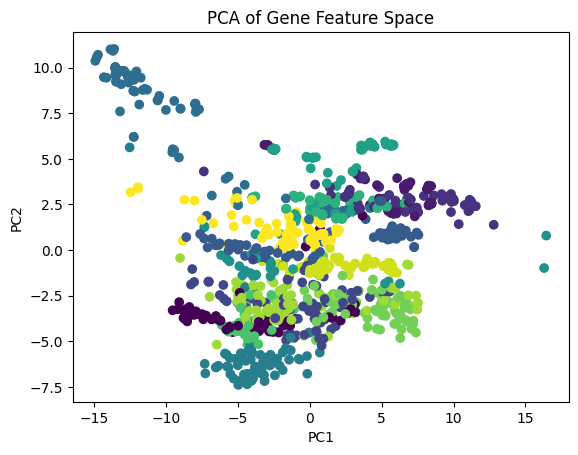

In [10]:
#PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train.astype('category').cat.codes)
plt.title("PCA of Gene Feature Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [11]:
#Top importance scores in the model
importances = clf_rf.feature_importances_
indices = np.argsort(importances)[::-1]

for i in range(10):
    print(f"{X.columns[indices[i]]}: {importances[indices[i]]}")

cds_length: 0.0591961363010926
protein length: 0.0534674432259277
cds_end: 0.04738703508862621
aa_L: 0.042204918801266735
aa_C: 0.03260381974556565
aa_W: 0.03259064604697364
aa_Q: 0.031919858798141035
codon_TGG: 0.02997160925999917
aa_F: 0.029708791747729255
Sequence_length: 0.027114286239813587


# Mutation Impact Modeling 
First section describes Gene Function Classification where we load the cleaned features csv file. This section describes mutation impact modeling where we build a separate synthetic dataset where we simulate point mutations in CDS sequences and train a model to predict mutation impact. 

In [12]:
GENES_FILE = "Genes.txt"
SEQ_ROOT = Path("sequences")

def load_all_cds_sequences():
    #Loads all CDS sequences
    rows = []
    with open(GENES_FILE) as f:
        genes = [line.strip() for line in f if line.strip()]
    for gene in genes:
        cds_path = SEQ_ROOT / gene / f"{gene}_cds.fasta"
        # Parses all CDS entries for this gene from FASTA
        if not cds_path.exists():
            print(f"Missing CDS fasta for {gene}, skipping.")
            continue
        for record in SeqIO.parse(str(cds_path), "fasta"):
            rows.append({
                "Gene Name": gene,
                "cds_id": record.id,
                "cds_seq": str(record.seq),
            })
    return pd.DataFrame(rows)

# Nucleotides used for mutations
NUCS = ["A", "C", "G", "T"]

def mutate_cds_once(cds_seq: str) -> str:
    #Introduces a single random point mutation in frame at one base in one codon
    L = len(cds_seq) - (len(cds_seq) % 3) # keep sequences in-frame
    cds_seq = cds_seq[:L]
    if L == 0:
        return cds_seq

    # Randomly picks a codon and a position within that codon (0, 1, or 2)
    codon_idx = random.randrange(L // 3)
    pos_in_codon = random.randrange(3)

    seq_list = list(cds_seq)
    idx = codon_idx * 3 + pos_in_codon
    original = seq_list[idx]

    # Changes base to a different nucleotide
    choices = [n for n in NUCS if n != original]
    seq_list[idx] = random.choice(choices)
    return "".join(seq_list)

def translate_cds(cds_seq: str) -> str:
    #Translates CDS to protein, stopping at the first stop codon
    return str(Seq(cds_seq).translate(to_stop=True))

def mutation_impact_metrics(orig_cds: str):
    # Simulates one mutation and compute simple impact metrics
    orig_prot = translate_cds(orig_cds)
    mut_cds = mutate_cds_once(orig_cds)
    mut_prot = translate_cds(mut_cds)

    # Skip cases where translation fails 
    if len(orig_prot) == 0 or len(mut_prot) == 0:
        return None

    # Counts amino acid differences and length changes
    min_len = min(len(orig_prot), len(mut_prot))
    diff = sum(o != m for o, m in zip(orig_prot[:min_len], mut_prot[:min_len]))
    diff += abs(len(orig_prot) - len(mut_prot))

    # Fractions of original protein that changed (sequence + length)
    impact_score = diff / len(orig_prot)

    # Flags if mutation introduced a premature stop codon (shorter protein)
    stop_introduced = len(mut_prot) < len(orig_prot)
    
    return {
        "orig_cds": orig_cds,
        "mut_cds": mut_cds,
        "orig_prot_len": len(orig_prot),
        "mut_prot_len": len(mut_prot),
        "impact_score": impact_score,
        "stop_introduced": int(stop_introduced),
    }

def gc_content(seq: str) -> float:
    # Computes GC-content (fraction of G and C nucleotides)
    return gc_fraction(seq)


In [13]:
# Load all original CDS sequences for the selected genes
cds_df = load_all_cds_sequences()
cds_df.head()


,Gene Name,cds_id,cds_seq
0,BRCA1,BRCA1_CDS,ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...
1,DMD,DMD_CDS,ATGGCGGAGGGTGTGCGACCCGAGGACTATTGCGACGAGGTGCTGG...
2,HTT,HTT_CDS,ATGACATCGTTAAGCAACGTACTGAAAGCCATAGAGGCTCTAAAAA...
3,TP53,TP53_CDS,ATGATGGAAGAGCAAAATAATGACAGTCTGCAGTTGGGTCAGGACC...
4,APOE,APOE_CDS,ATGAGAGATAGCGAAAACCCACTGTTACTGCCGTTTATTGAGCACC...


In [14]:
def build_mutation_dataset(cds_df, n_mutations_per_seq=5):
    # For each CDS, simulate multiple random point mutations
    rows = []
    for _, row in cds_df.iterrows():
        gene = row["Gene Name"]
        cds = row["cds_seq"]
        for i in range(n_mutations_per_seq):
            metrics = mutation_impact_metrics(cds)
            if metrics is None:
                continue
            # Attach gene-level metadata and mutation index
            metrics["Gene Name"] = gene
            metrics["cds_id"] = row["cds_id"]
            metrics["mutation_idx"] = i
            rows.append(metrics)
    return pd.DataFrame(rows)

# Generate synthetic mutation dataset (multiple mutations per CDS)
mut_df = build_mutation_dataset(cds_df, n_mutations_per_seq=5)
mut_df.head()


,orig_cds,mut_cds,orig_prot_len,mut_prot_len,impact_score,stop_introduced,Gene Name,cds_id,mutation_idx
0,ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...,ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...,1808,1808,0.000553,0,BRCA1,BRCA1_CDS,0
1,ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...,ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...,1808,1808,0.000553,0,BRCA1,BRCA1_CDS,1
2,ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...,ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...,1808,1808,0.000553,0,BRCA1,BRCA1_CDS,2
3,ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...,ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...,1808,1808,0.000553,0,BRCA1,BRCA1_CDS,3
4,ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...,ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...,1808,109,0.939712,1,BRCA1,BRCA1_CDS,4


In [15]:
# GC-content features (original vs mutated CDS)
mut_df["orig_GC"] = mut_df["orig_cds"].apply(gc_content)
mut_df["mut_GC"]  = mut_df["mut_cds"].apply(gc_content)
mut_df["delta_GC"] = mut_df["mut_GC"] - mut_df["orig_GC"]

# Change in protein length due to mutation
mut_df["delta_len"] = mut_df["mut_prot_len"] - mut_df["orig_prot_len"]

# Binary label: top 20% of impact_score = "high impact" mutations
threshold = mut_df["impact_score"].quantile(0.8)
mut_df["high_impact"] = (mut_df["impact_score"] >= threshold).astype(int)

mut_df["high_impact"].value_counts(), mut_df.head()


(high_impact
 0    60
 1    15
 Name: count, dtype: int64,
                                             orig_cds  \
 0  ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...   
 1  ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...   
 2  ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...   
 3  ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...   
 4  ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...   
 
                                              mut_cds  orig_prot_len  \
 0  ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...           1808   
 1  ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...           1808   
 2  ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...           1808   
 3  ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...           1808   
 4  ATGGATTTATCTGCAGTTCGTGTTGAAGAAGTACAAAATGTCCTTA...           1808   
 
    mut_prot_len  impact_score  stop_introduced Gene Name     cds_id  \
 0          1808      0.000553                0     BRCA1  BRCA1_CDS   
 1          1808   

In [16]:
feature_cols_mut = ["orig_GC", "mut_GC", "delta_GC", "delta_len", "orig_prot_len"]
X_mut = mut_df[feature_cols_mut]
y_mut = mut_df["high_impact"]

# Train/test split for mutation-impact model
X_mut_train, X_mut_test, y_mut_train, y_mut_test = train_test_split(
    X_mut, y_mut, test_size=0.25, stratify=y_mut, random_state=42
)

# Random Forest classifier for predicting high-impact mutations
clf_mut_rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
)
clf_mut_rf.fit(X_mut_train, y_mut_train)

# Evaluate classification performance
y_mut_pred = clf_mut_rf.predict(X_mut_test)
print(classification_report(y_mut_test, y_mut_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         4

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



SHAP: (19, 5)
X: (19, 5)


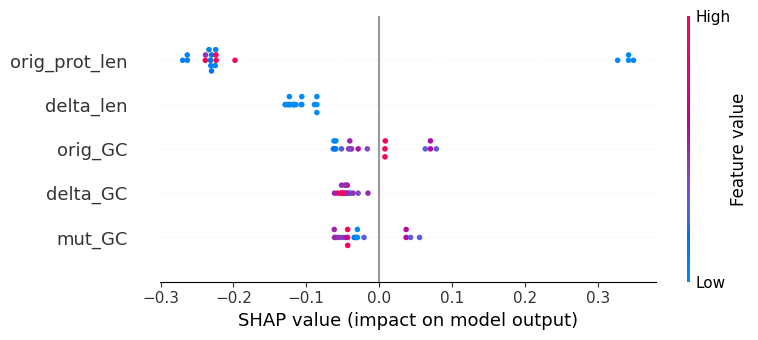

In [17]:
# Make DataFrame for SHAP with named columns
X_mut_test_df = pd.DataFrame(X_mut_test, columns=feature_cols_mut)

# TreeExplainer for Random Forest
explainer_mut = shap.TreeExplainer(clf_mut_rf)
raw_shap = explainer_mut.shap_values(X_mut_test_df)

# For RandomForestClassifier, SHAP returns list [class0, class1] or a 3D array
# We focus on class 1 = high-impact mutations
if isinstance(raw_shap, list):
    shap_class1 = raw_shap[1]  # SHAP values for class 1
else:
    # raw_shap has shape (samples, features, classes)
    shap_class1 = raw_shap[:, :, 1]

# If SHAP is 3D (interactions), reduce to main effects
if shap_class1.ndim == 3:
    # Keep only main diagonal of interactions as main effect
    shap_class1 = shap_class1[:, :, 1]

# Ensure shapes match
print("SHAP:", shap_class1.shape)
print("X:", X_mut_test_df.shape)

# Summary plot showing which features drive high-impact predictions
shap.summary_plot(shap_class1, X_mut_test_df, feature_names=feature_cols_mut)


In [18]:
# Fit regression model on same feature set to predict impact_score directly
lr_mut = LinearRegression()
lr_mut.fit(X_mut_train, mut_df.loc[X_mut_train.index, "impact_score"])
# Predict on test set and compute RMSE
y_mut_pred_reg = lr_mut.predict(X_mut_test)
rmse = np.sqrt(mean_squared_error(mut_df.loc[X_mut_test.index, "impact_score"], y_mut_pred_reg))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.0168


' We chose a Random Forest for mutation-impact prediction because it\n    captures non-linear feature interactions and handles class imbalance\n    better than Logistic Regression, which under-performed on minority recall. '

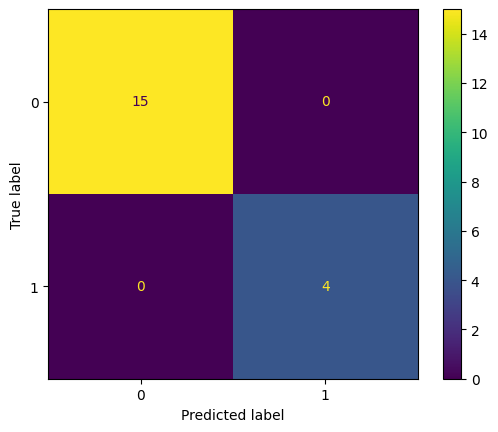

In [19]:
ConfusionMatrixDisplay.from_estimator(clf_mut_rf, X_mut_test, y_mut_test)
""" We chose a Random Forest for mutation-impact prediction because it
    captures non-linear feature interactions and handles class imbalance
    better than Logistic Regression, which under-performed on minority recall. """

We chose to perform a Random Forest Model for mutation-impact prediction because the feature interactions are nonlinear. When trying to use Logistic Regression, it performed poorly on minority-class recall, while Random Forest handled class imbalance and nonlinearity effectively.